<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

# 0. Libraries

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors

import torch
from torch import nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Our VAE class
from VariationalModel import *

In [9]:
# def entropy_knn(X, k=3):
#     """
#     Stima l'entropia usando k-nearest neighbors.
#     Più robusto di KDE per alta dimensione.
#     """
#     if isinstance(X, torch.Tensor):
#         X = X.detach().cpu().numpy()
    
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
    
#     n_samples, n_features = X.shape
    
#     # Trova k-nearest neighbors
#     nbrs = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(X)
#     distances, _ = nbrs.kneighbors(X)
    
#     # Distanza al k-esimo vicino (escludendo se stesso)
#     radius = distances[:, -1]
    
#     # Formula di Kozachenko-Leonenko
#     volume_unit_ball = np.pi ** (n_features / 2) / np.exp(digamma(n_features / 2 + 1))
    
#     H = (n_features * np.mean(np.log(radius + 1e-10)) + 
#          np.log(volume_unit_ball) + 
#          digamma(n_samples) - 
#          digamma(k))
    
#     return max(0, H)


# def mutual_info_knn(X, Y, k=3):
#     """
#     Stima I(X;Y) usando k-nearest neighbors (Kraskov estimator).
#     Questo è robusto anche per dimensioni medio-alte.
#     """
#     if isinstance(X, torch.Tensor):
#         X = X.detach().cpu().numpy()
#     if isinstance(Y, torch.Tensor):
#         Y = Y.detach().cpu().numpy()
    
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
#     if Y.ndim == 1:
#         Y = Y.reshape(-1, 1)
    
#     # Normalizza
#     X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)
#     Y = (Y - Y.mean(axis=0)) / (Y.std(axis=0) + 1e-10)
    
#     n_samples = X.shape[0]
    
#     # Concatena per spazio congiunto
#     XY = np.hstack([X, Y])
    
#     # Trova k-NN nello spazio congiunto
#     nbrs_joint = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(XY)
#     distances_joint, _ = nbrs_joint.kneighbors(XY)
#     epsilon = distances_joint[:, -1]
    
#     # Conta neighbors entro epsilon in X e Y separatamente
#     nbrs_X = NearestNeighbors(metric='chebyshev').fit(X)
#     nbrs_Y = NearestNeighbors(metric='chebyshev').fit(Y)
    
#     n_x = np.array([len(nbrs_X.radius_neighbors([x], epsilon[i])[1][0]) - 1 
#                     for i, x in enumerate(X)])
#     n_y = np.array([len(nbrs_Y.radius_neighbors([y], epsilon[i])[1][0]) - 1 
#                     for i, y in enumerate(Y)])
    
#     # Formula di Kraskov
#     mi = digamma(k) - np.mean(digamma(n_x + 1) + digamma(n_y + 1)) + digamma(n_samples)
    
#     return max(0, mi)


# # ============================================
# # 2. MI rispetto ai LABELS (come Saxe!)
# # ============================================

# def mutual_info_discrete_continuous(T, labels, bins=30):
#     """
#     Calcola I(T; Y) dove:
#     - T = attivazioni continue (N, D)
#     - labels = labels discreti (N,) con valori in {0, 1, ..., K-1}
    
#     Questo è quello che fa Saxe nel paper!
#     """
#     if isinstance(T, torch.Tensor):
#         T = T.detach().cpu().numpy()
#     if isinstance(labels, torch.Tensor):
#         labels = labels.detach().cpu().numpy()
    
#     n_samples = T.shape[0]
#     n_classes = len(np.unique(labels))
    
#     # H(Y) - entropia dei label
#     label_counts = np.bincount(labels)
#     p_y = label_counts / n_samples
#     H_Y = -np.sum(p_y * np.log2(p_y + 1e-10))
    
#     # H(Y|T) - entropia condizionale
#     # Discretizza T
#     T_discrete = np.zeros_like(T, dtype=int)
#     for d in range(T.shape[1]):
#         T_discrete[:, d] = np.digitize(T[:, d], 
#                                         np.linspace(T[:, d].min(), T[:, d].max(), bins))
    
#     # Converti ogni riga in un simbolo
#     T_symbols = [''.join(map(str, row)) for row in T_discrete]
    
#     # Calcola p(y|t) per ogni t
#     H_Y_given_T = 0
#     from collections import defaultdict
    
#     # Raggruppa per simbolo T
#     t_to_labels = defaultdict(list)
#     for t_sym, y in zip(T_symbols, labels):
#         t_to_labels[t_sym].append(y)
    
#     # Per ogni gruppo, calcola H(Y|T=t)
#     for t_sym, y_list in t_to_labels.items():
#         p_t = len(y_list) / n_samples
        
#         # Distribuzione di Y dato T=t
#         y_counts = np.bincount(y_list, minlength=n_classes)
#         p_y_given_t = y_counts / len(y_list)
        
#         # H(Y|T=t)
#         H_y_t = -np.sum(p_y_given_t * np.log2(p_y_given_t + 1e-10))
        
#         H_Y_given_T += p_t * H_y_t
    
#     # I(T;Y) = H(Y) - H(Y|T)
#     mi = H_Y - H_Y_given_T
    
#     return max(0, mi)


# # ============================================
# # 3. FUNZIONE PRINCIPALE - Versione Saxe
# # ============================================

# def VAE_info_saxe(model, dataset, device='cpu', num_samples=6000, k=3):
#     """
#     Calcola MI come nel paper di Saxe:
#     - Encoder: I(T; Y_labels) e I(T; Z)
#     - Decoder: I(T; Z) e I(T; Y_labels)
    
#     Usa k-NN per robustezza in alta dimensione.
#     """
#     model.eval()
#     model.to(device)
    
#     # Prendi campioni con labels
#     indices = np.random.choice(len(dataset), num_samples, replace=False)
    
#     X_list = []
#     Y_labels = []
    
#     for idx in indices:
#         img, label = dataset[idx]
#         X_list.append(img)
#         Y_labels.append(label)
    
#     X_batch = torch.stack(X_list).to(device)
#     Y_labels = np.array(Y_labels)
    
#     # Forward pass
#     with torch.no_grad():
#         outputs, z = model(X_batch)
    
#     # Prepara dati
#     X_data = X_batch.view(X_batch.size(0), -1).detach().cpu().numpy()
#     Z_data = activations["latent_space"].detach().cpu().numpy()
#     Y_data = activations["output_space"].detach().cpu().numpy()
    
#     mi = {"encoder": [], "decoder": []}
    
#     print("Calculating Encoder MI (using labels like Saxe)...")
#     for i in range(1, len(model.Encoder) + 1):
#         act = activations[f"encoder_layer_{i}"]
#         act = act.view(act.size(0), -1).detach().cpu().numpy()
        
#         # I(T; Y_labels) - MI rispetto alle classi
#         mi_labels = mutual_info_discrete_continuous(act, Y_labels, bins=20)
        
#         # I(T; Z) - MI rispetto allo spazio latente (KNN)
#         mi_z = mutual_info_knn(act, Z_data, k=k)
        
#         mi["encoder"].append((mi_labels, mi_z))
#         print(f"  Layer {i}: I(T;Labels)={mi_labels:.3f}, I(T;Z)={mi_z:.3f}")
    
#     print("Calculating Decoder MI...")
#     for i in range(1, len(model.Decoder) + 1):
#         act = activations[f"decoder_layer_{i}"]
#         act = act.view(act.size(0), -1).detach().cpu().numpy()
        
#         # I(T; Z)
#         mi_z = mutual_info_knn(act, Z_data, k=k)
        
#         # I(T; Y_labels) - MI rispetto alle classi (output)
#         mi_labels = mutual_info_discrete_continuous(act, Y_labels, bins=20)
        
#         mi["decoder"].append((mi_z, mi_labels))
#         print(f"  Layer {i}: I(T;Z)={mi_z:.3f}, I(T;Labels)={mi_labels:.3f}")
    
#     return mi


# # ============================================
# # 4. TRAINING MODIFICATO
# # ============================================

# def Training(model, num_epochs=10, showImage=False):
#     setup_hooks(model)
    
#     for epoch in range(num_epochs):
#         model.train()
#         losses = []
        
#         for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#             images = images.to(device)
#             outputs, z = model(images)
#             targets = images.view(images.size(0), -1)
#             loss = loss_fn(outputs, targets)
            
#             optim.zero_grad()
#             loss.backward()
#             optim.step()
            
#             losses.append(loss.detach().cpu().numpy())
        
#         avg_loss = np.mean(losses)
#         train_loss_history.append(avg_loss)
        
#         # Calcola MI (ogni 2 epoche per velocità)
#         if (epoch + 1) % 2 == 0 or epoch == 0:
#             res = VAE_info_saxe(model, trainDataset, device, num_samples=5000, k=5)
#             history_encoder.append(res['encoder'])
#             history_decoder.append(res['decoder'])
        
#         print(f"TRAIN — Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")
        
#         if showImage and epoch % 5 == 0:
#             model.eval()
#             img = testDataset[0][0].unsqueeze(0).to(device)
#             with torch.no_grad():
#                 recon = model(img)[0]
            
#             fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#             axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
#             axs[0].set_title("Original")
#             axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
#             axs[1].set_title(f"Reconstruction (epoch {epoch+1})")
#             plt.tight_layout()
#             plt.show()
    
#     return avg_loss


# # # ============================================
# # # 5. PLOT MIGLIORATO
# # # ============================================

# # def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix=""):
# #     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
# #     epochs = len(mi_history_encoder)
# #     cmap = plt.get_cmap('plasma')
# #     colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]
    
# #     # ENCODER
# #     ax = axes[0]
# #     n_layers = len(mi_history_encoder[0])
    
# #     for l in range(n_layers):
# #         x = [e[l][0] for e in mi_history_encoder]  # I(T; Labels)
# #         y = [e[l][1] for e in mi_history_encoder]  # I(T; Z)
        
# #         # Traccia
# #         ax.plot(x, y, 'o-', alpha=0.4, linewidth=2.5, 
# #                 label=f'Layer {l+1}', markersize=10)
        
# #         # Colora punti per epoca
# #         for ep in range(epochs):
# #             ax.scatter(x[ep], y[ep], c=[colors[ep]], 
# #                       s=100, edgecolors='black', linewidths=1, zorder=10)
    
# #     ax.set_xlabel("I(Layer; Output Labels)", fontsize=13, fontweight='bold')
# #     ax.set_ylabel("I(Layer; Latent Z)", fontsize=13, fontweight='bold')
# #     ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=15, fontweight='bold')
# #     ax.legend(loc='best', framealpha=0.9)
# #     ax.grid(True, alpha=0.3, linestyle='--')
    
# #     # DECODER
# #     ax = axes[1]
# #     n_layers = len(mi_history_decoder[0])
    
# #     for l in range(n_layers):
# #         x = [e[l][0] for e in mi_history_decoder]  # I(T; Z)
# #         y = [e[l][1] for e in mi_history_decoder]  # I(T; Labels)
        
# #         ax.plot(x, y, 'o-', alpha=0.4, linewidth=2.5,
# #                 label=f'Layer {l+1}', markersize=10)
        
# #         for ep in range(epochs):
# #             ax.scatter(x[ep], y[ep], c=[colors[ep]],
# #                       s=100, edgecolors='black', linewidths=1, zorder=10)
    
# #     ax.set_xlabel("I(Layer; Latent Z)", fontsize=13, fontweight='bold')
# #     ax.set_ylabel("I(Layer; Output Labels)", fontsize=13, fontweight='bold')
# #     ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=15, fontweight='bold')
# #     ax.legend(loc='best', framealpha=0.9)
# #     ax.grid(True, alpha=0.3, linestyle='--')
    
# #     # Colorbar
# #     sm = plt.cm.ScalarMappable(cmap=cmap, 
# #                                norm=plt.Normalize(vmin=0, vmax=epochs-1))
# #     sm.set_array([])
# #     cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), 
# #                         label="Training Epoch", aspect=40)
    
# #     plt.tight_layout()
# #     plt.show()


# # ============================================
# # 6. ESECUZIONE
# # ============================================

# # # Reset histories
# # history_encoder = []
# # history_decoder = []
# # train_loss_history = []

# # # Train
# # epochs = 30
# # final_loss = Training(model, num_epochs=epochs, showImage=False)

# # # Plot
# # PlotInfoPlane(history_encoder, history_decoder)

# 1. Set up

## Tracking Layers

In [10]:
class ActivationRecorder:
    """
    Stores activations across epochs.

    Geometry:

        encoder[layer][epoch] → (N, neurons_in_layer)
        decoder[layer][epoch] → (N, neurons_in_layer)
        latent[epoch]         → (N, latent_dim)
        output[epoch]         → (N, output_dim)
    """

    def __init__(self):
        self.encoder = {}
        self.decoder = {}
        self.latent = {}
        self.output = {}

        self._current = {}

    # ---------- HOOK SYSTEM ----------

    def hook(self, name):
        def _hook(module, inputs, output):
            self._current[name] = output.detach().cpu().numpy()
        return _hook

    def register(self, model):
        self._current.clear()

        for i, layer in enumerate(model.Encoder):
            layer.register_forward_hook(self.hook(f"encoder_layer_{i+1}"))

        for i, layer in enumerate(model.Decoder):
            layer.register_forward_hook(self.hook(f"decoder_layer_{i+1}"))

        model.LatentSpace.register_forward_hook(self.hook("latent_space"))
        model.OutputSpace.register_forward_hook(self.hook("output_space"))

    # ---------- STORE EPOCH ----------

    def record_epoch(self, epoch):
        for name, value in self._current.items():
            if name.startswith("encoder"):
                self.encoder.setdefault(name, {})[epoch] = value
            elif name.startswith("decoder"):
                self.decoder.setdefault(name, {})[epoch] = value
            elif name == "latent_space":
                self.latent[epoch] = value
            elif name == "output_space":
                self.output[epoch] = value

    # ---------- ACCESS API ----------

    def get(self, name, epoch):
        if name.startswith("encoder"):
            return self.encoder[name][epoch]
        if name.startswith("decoder"):
            return self.decoder[name][epoch]
        if name == "latent_space":
            return self.latent[epoch]
        if name == "output_space":
            return self.output[epoch]
        raise KeyError(name)

    def get_neuron(self, name, neuron_idx, epoch):
        return self.get(name, epoch)[:, neuron_idx:neuron_idx+1]

In [11]:
class MIHistory:
    def __init__(self):
        self.encoder = []
        self.decoder = []
        self.input_latent = []
        self.latent_output = []

    def append(self, mi_dict):
        self.encoder.append(mi_dict["encoder"])
        self.decoder.append(mi_dict["decoder"])
        self.input_latent.append(mi_dict["input_latent"])
        self.latent_output.append(mi_dict["latent_output"])

## Mutual Info Estimation (KDE method)

In [12]:
class KDEEstimator:
    """
    KDE estimator in R^d.

    Data shape: (N, d)
        N = samples
        d = neurons (layer dimensionality)
    """

    def __init__(self, sigma):
        self.sigma = sigma
        self.last_distances = None
        self.last_density = None

    def pairwise_distances(self, X):
        X = np.asarray(X)
        sq = np.sum(X**2, axis=1, keepdims=True)
        dist2 = sq + sq.T - 2 * X @ X.T
        self.last_distances = np.sqrt(np.maximum(dist2, 0))
        return self.last_distances

    def density(self, X):
        X = np.asarray(X)
        N, d = X.shape

        D = self.pairwise_distances(X)

        sigma_d = self.sigma * np.sqrt(d)

        K = np.exp(-(D**2) / (2 * sigma_d**2))
        rho = K.mean(axis=1)

        self.last_density = rho
        return rho

    def entropy(self, X):
        rho = self.density(X)
        return -np.mean(np.log(rho + 1e-10))

    def mutual_information(self, X, Y):
        HX = self.entropy(X)
        HY = self.entropy(Y)
        HXY = self.entropy(np.concatenate([X, Y], axis=1))
        return HX + HY - HXY

In [24]:
def VAE_info(model, dataset, device, num_samples, epoch, kde: KDEEstimator, Recorder: ActivationRecorder):
    model.eval()
    model.to(device)
    
    loader = torch.utils.data.DataLoader( dataset, batch_size=num_samples, shuffle=True )
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        model(inputs)

    X = inputs.view(inputs.size(0), -1).cpu().numpy()
    Z = RecorderActivat.get("latent_space", epoch)
    Y = RecorderActivat.get("output_space", epoch)


    mi = {
        "encoder": [],
        "decoder": [],
        "input_latent": None,
        "latent_output": None
    }

    # Encoder layers
    for i in range(len(model.Encoder)):
        A = Recorder.get(f"encoder_layer_{i+1}", epoch)
        mi["encoder"].append((
            kde.mutual_information(A, X),
            kde.mutual_information(A, Z)
        ))

    # Decoder layers
    for i in range(len(model.Decoder)):
        A = Recorder.get(f"decoder_layer_{i+1}", epoch)
        mi["decoder"].append((
            kde.mutual_information(A, Z),
            kde.mutual_information(A, Y)
        ))

    mi["input_latent"] = kde.mutual_information(X, Z)
    mi["latent_output"] = kde.mutual_information(Z, Y)

    return mi

## Dataset

In [14]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

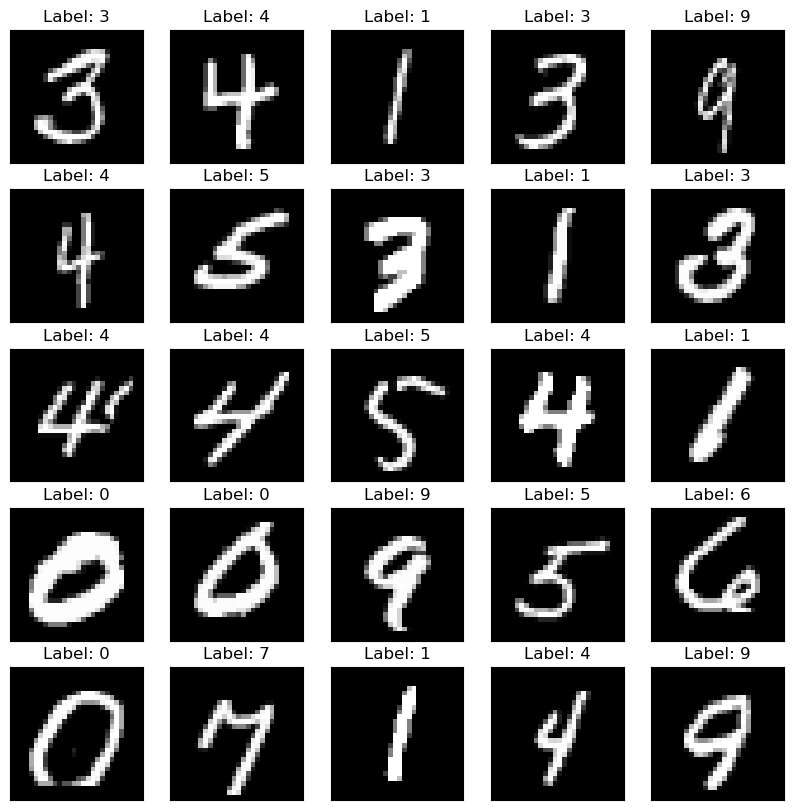

In [15]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [16]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [17]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])
TEST BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])


# 2. VAE model

## Set up model

In [25]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[200, 150, 100, 50], Variational = True)

In [26]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: cuda


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): ReLU()
    )
  )
  (LatentLayerMu): Linear(in_features=50, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=50, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=150, bias=True)
      (1): ReLU(

## Training Model

In [27]:
def Training(model, num_epochs, sampleMI=1000, sigmaMI=1, showImage=False, doTest=False):
    RecorderActivat.register(model) # setting hooks


    kde = KDEEstimator(sigmaMI)

    
    for epoch in range(num_epochs):
        model.train()
        losses = []

        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)

            outputs, z = model(images)
            targets = images.view(images.size(0), -1)

            loss = loss_fn(outputs, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().cpu().numpy())

        avg_train_loss = np.mean(losses)
        train_loss_history.append(avg_train_loss)

        # -------- Validation loss (optional) --------
        if doTest:
            model.eval()
            val_losses = []

            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)

                    outputs, z = model(images)
                    targets = images.view(images.size(0), -1)

                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.cpu().numpy())

            avg_val_loss = np.mean(val_losses)
            val_loss_history.append(avg_val_loss)
        else:
            avg_val_loss = None  # no validation this epoch

        # -------- Mutual Information --------
        #kde = KDEEstimator(sigmaMI)

        RecorderActivat.record_epoch(epoch)
        
        res = VAE_info(
            model,
            trainDataset,
            device,
            num_samples=sampleMI,
            epoch=epoch,
            kde=kde,
            Recorder=RecorderActivat
        )
        mi_history.append(res)

        # Print depending on validation flag
        if doTest:
            print(
                f"TRAIN — Epoch {epoch+1}/{num_epochs} — "
                f"train loss: {avg_train_loss:.4f} — "
                f"val loss: {avg_val_loss:.4f}"
            )
        else:
            print(
                f"TRAIN — Epoch {epoch+1}/{num_epochs} — "
                f"train loss: {avg_train_loss:.4f}"
            )

        # -------- Optional reconstruction preview --------
        if showImage:
            img = testDataset[0][0].unsqueeze(0).to(device)

            with torch.no_grad():
                recon = model(img)[0]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original image")

            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Reconstruction (epoch {epoch+1})")

            plt.tight_layout()
            plt.show()
            plt.close()

    return np.mean(losses)

In [29]:
epochs = 10

train_loss_history = []
val_loss_history = []

RecorderActivat = ActivationRecorder() # qui dentro si può prendere l'epochs se serve
mi_history = MIHistory()

In [30]:
final_loss = Training(model, num_epochs=epochs, showImage=False, sampleMI=1000, sigmaMI=5)

Epoch 1/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.21it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 500 and the array at index 1 has size 1000

In [31]:
class ActivationRecorder:
    """
    Stores activations across epochs.
    Structure:
        encoder[layer][epoch] → (N, neurons)
        decoder[layer][epoch] → (N, neurons)
        latent[epoch] → (N, latent_dim)
        output[epoch] → (N, output_dim)
    """
    def __init__(self):
        self.encoder = {}
        self.decoder = {}
        self.latent = {}
        self.output = {}
        self._current = {}
        self._buffer = {}  # Accumulate batches
        
    def hook(self, name):
        def _hook(module, inputs, output):
            self._current[name] = output.detach().cpu().numpy()
        return _hook
    
    def register(self, model):
        self._current.clear()
        for i, layer in enumerate(model.Encoder):
            layer.register_forward_hook(self.hook(f"encoder_layer_{i+1}"))
        for i, layer in enumerate(model.Decoder):
            layer.register_forward_hook(self.hook(f"decoder_layer_{i+1}"))
        model.LatentSpace.register_forward_hook(self.hook("latent_space"))
        model.OutputSpace.register_forward_hook(self.hook("output_space"))
    
    def accumulate_batch(self):
        """Add current batch to buffer"""
        for name, value in self._current.items():
            if name not in self._buffer:
                self._buffer[name] = []
            self._buffer[name].append(value)
    
    def get_accumulated(self, name, max_samples=None):
        """Get concatenated activations from buffer"""
        if name not in self._buffer or len(self._buffer[name]) == 0:
            return None
        concat = np.concatenate(self._buffer[name], axis=0)
        if max_samples is not None and concat.shape[0] > max_samples:
            concat = concat[:max_samples]
        return concat
    
    def record_epoch(self, epoch):
        """Save buffer to permanent storage and clear"""
        for name in self._buffer.keys():
            concat = self.get_accumulated(name)
            if name.startswith("encoder"):
                self.encoder.setdefault(name, {})[epoch] = concat
            elif name.startswith("decoder"):
                self.decoder.setdefault(name, {})[epoch] = concat
            elif name == "latent_space":
                self.latent[epoch] = concat
            elif name == "output_space":
                self.output[epoch] = concat
        self._buffer.clear()
    
    def clear_buffer(self):
        """Clear buffer without saving"""
        self._buffer.clear()
    
    def get(self, name, epoch):
        if name.startswith("encoder"):
            return self.encoder[name][epoch]
        if name.startswith("decoder"):
            return self.decoder[name][epoch]
        if name == "latent_space":
            return self.latent[epoch]
        if name == "output_space":
            return self.output[epoch]
        raise KeyError(name)


class MIHistory:
    def __init__(self):
        self.encoder = []
        self.decoder = []
        self.input_latent = []
        self.latent_output = []
    
    def append(self, mi_dict):
        self.encoder.append(mi_dict["encoder"])
        self.decoder.append(mi_dict["decoder"])
        self.input_latent.append(mi_dict["input_latent"])
        self.latent_output.append(mi_dict["latent_output"])


class KDEEstimator:
    def __init__(self, sigma):
        self.sigma = sigma
    
    def pairwise_distances(self, X):
        X = np.asarray(X)
        sq = np.sum(X**2, axis=1, keepdims=True)
        dist2 = sq + sq.T - 2 * X @ X.T
        return np.sqrt(np.maximum(dist2, 0))
    
    def density(self, X):
        X = np.asarray(X)
        N, d = X.shape
        D = self.pairwise_distances(X)
        sigma_d = self.sigma * np.sqrt(d)
        K = np.exp(-(D**2) / (2 * sigma_d**2))
        return K.mean(axis=1)
    
    def entropy(self, X):
        rho = self.density(X)
        return -np.mean(np.log(rho + 1e-10))
    
    def mutual_information(self, X, Y):
        HX = self.entropy(X)
        HY = self.entropy(Y)
        HXY = self.entropy(np.concatenate([X, Y], axis=1))
        return HX + HY - HXY


def VAE_info_from_buffer(model, Recorder: ActivationRecorder, kde: KDEEstimator, 
                          input_data, num_samples=None):
    """
    Compute MI using accumulated activations from buffer.
    Much faster - no additional forward pass needed!
    """
    X = input_data.view(input_data.size(0), -1).cpu().numpy()
    
    if num_samples is not None:
        X = X[:num_samples]
    
    Z = Recorder.get_accumulated("latent_space", num_samples)
    Y = Recorder.get_accumulated("output_space", num_samples)
    
    mi = {
        "encoder": [],
        "decoder": [],
        "input_latent": None,
        "latent_output": None
    }
    
    for i in range(len(model.Encoder)):
        A = Recorder.get_accumulated(f"encoder_layer_{i+1}", num_samples)
        mi["encoder"].append((
            kde.mutual_information(A, X),
            kde.mutual_information(A, Z)
        ))
    
    for i in range(len(model.Decoder)):
        A = Recorder.get_accumulated(f"decoder_layer_{i+1}", num_samples)
        mi["decoder"].append((
            kde.mutual_information(A, Z),
            kde.mutual_information(A, Y)
        ))
    
    mi["input_latent"] = kde.mutual_information(X, Z)
    mi["latent_output"] = kde.mutual_information(Z, Y)
    
    return mi


def Training(model, num_epochs, sampleMI=4000, sigmaMI=1, showImage=False, doTest=False):
    RecorderActivat.register(model)
    kde = KDEEstimator(sigmaMI)
    
    for epoch in range(num_epochs):
        model.train()
        losses = []
        
        RecorderActivat.clear_buffer()
        accumulated_inputs = []
        
        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            outputs, z = model(images)
            targets = images.view(images.size(0), -1)
            loss = loss_fn(outputs, targets)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.detach().cpu().numpy())
            
            # Accumulate activations + inputs
            with torch.no_grad():
                RecorderActivat.accumulate_batch()
                accumulated_inputs.append(images.cpu())
                
                # Stop if we have enough samples
                if len(accumulated_inputs) * images.size(0) >= sampleMI:
                    break
        
        avg_train_loss = np.mean(losses)
        train_loss_history.append(avg_train_loss)
        
        # Validation (optional)
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    outputs, z = model(images)
                    targets = images.view(images.size(0), -1)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.cpu().numpy())
            avg_val_loss = np.mean(val_losses)
            val_loss_history.append(avg_val_loss)
        else:
            avg_val_loss = None
        
        # Compute MI from accumulated activations (no extra forward pass!)
        all_inputs = torch.cat(accumulated_inputs, dim=0)
        res = VAE_info_from_buffer(
            model, 
            RecorderActivat, 
            kde, 
            all_inputs,
            num_samples=sampleMI
        )
        mi_history.append(res)
        
        # Save epoch (transfer buffer → permanent storage)
        RecorderActivat.record_epoch(epoch)
        
        # Print
        if doTest:
            print(f"Epoch {epoch+1}/{num_epochs} — "
                  f"train: {avg_train_loss:.4f} — val: {avg_val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} — train: {avg_train_loss:.4f}")
        
        # Reconstruction preview (optional)
        if showImage and epoch % 5 == 0:
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Recon (epoch {epoch+1})")
            plt.tight_layout()
            plt.show()
            plt.close()
    
    return np.mean(losses)


# Usage
epochs = 10
train_loss_history = []
val_loss_history = []
RecorderActivat = ActivationRecorder()
mi_history = MIHistory()

final_loss = Training(
    model, 
    num_epochs=epochs, 
    sampleMI=4000,  # Use first N samples from training
    sigmaMI=5,
    showImage=False,
    doTest=False
)

Epoch 1/10:   6%|██▊                                             | 7/120 [00:00<00:05, 22.44it/s]


Epoch 1/10 — train: 0.0663


Epoch 2/10:   6%|██▊                                             | 7/120 [00:00<00:02, 49.89it/s]


Epoch 2/10 — train: 0.0656


Epoch 3/10:   6%|██▊                                             | 7/120 [00:00<00:02, 51.08it/s]


Epoch 3/10 — train: 0.0655


Epoch 4/10:   6%|██▊                                             | 7/120 [00:00<00:02, 49.71it/s]


Epoch 4/10 — train: 0.0651


Epoch 5/10:   6%|██▊                                             | 7/120 [00:00<00:02, 53.00it/s]


Epoch 5/10 — train: 0.0650


Epoch 6/10:   6%|██▊                                             | 7/120 [00:00<00:02, 53.72it/s]


Epoch 6/10 — train: 0.0643


Epoch 7/10:   6%|██▊                                             | 7/120 [00:00<00:02, 51.98it/s]


Epoch 7/10 — train: 0.0634


Epoch 8/10:   6%|██▊                                             | 7/120 [00:00<00:02, 53.00it/s]


Epoch 8/10 — train: 0.0635


Epoch 9/10:   6%|██▊                                             | 7/120 [00:00<00:02, 54.20it/s]


Epoch 9/10 — train: 0.0625


Epoch 10/10:   6%|██▋                                            | 7/120 [00:00<00:02, 53.44it/s]


Epoch 10/10 — train: 0.0629


## Diagnostic distributions

In [32]:
def plot_kde_geometry(recorder, kde, part="encoder", layer=1, neuron=None, epoch=-1, bins=60):
    """
    neuron=None  → whole layer (R^d)
    neuron=k     → single neuron (R^1)
    """

    if part == "encoder":
        X = recorder.encoder[f"encoder_layer_{layer}"][epoch]
    elif part == "decoder":
        X = recorder.decoder[f"decoder_layer_{layer}"][epoch]
    elif part == "latent":
        X = recorder.latent[epoch]
    else:
        X = recorder.output[epoch]

    if neuron is not None:
        X = X[:, [neuron]]      # shape (N,1)

    rho = kde.density(X)
    D = kde.last_distances[np.triu_indices_from(kde.last_distances, k=1)]

    fig, axs = plt.subplots(1, 2, figsize=(11, 4))

    axs[0].hist(D, bins=bins, density=True)
    axs[0].set_title("Pairwise distances")

    axs[1].hist(rho, bins=bins, density=True)
    axs[1].set_title("Estimated density")

    plt.tight_layout()
    plt.show()

plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="encoder",
    layer=3,
    epoch=7
)

plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="encoder",
    layer=3,
    neuron=5,
    epoch=7
)

plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="latent",
    epoch=7
)

In [40]:
def plot_kde_geometry(recorder, kde, part="encoder", layer=1, neuron=None, epoch=None, bins=60):
    """
    Plot pairwise distances and estimated density for a recorded activation.

    Parameters
    ----------
    recorder : ActivationRecorder
        The recorder instance that stored activations.
    kde : KDEEstimator
        The KDE estimator instance (will compute density and distances).
    part : str
        One of "encoder", "decoder", "latent", "output".
    layer : int
        Layer index (1-based) for encoder/decoder.
    neuron : int or None
        If int, select a single neuron (column). If None, use whole layer.
    epoch : int or None
        Epoch index to read from recorder.
        If None, the function will try to use a global variable named `epoch` if present.
        If still None, defaults to -1 (latest recorded epoch).
        If -1, use the latest recorded epoch.
    bins : int
        Number of bins for histograms.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # If epoch is None, try to read a global variable named 'epoch'
    if epoch is None:
        epoch = globals().get('epoch', None)
    # If still None, default to -1 (latest)
    if epoch is None:
        epoch = -1

    # --- Resolve which storage and key to use ---
    if part == "encoder":
        storage = recorder.encoder
        key = f"encoder_layer_{layer}"
    elif part == "decoder":
        storage = recorder.decoder
        key = f"decoder_layer_{layer}"
    elif part == "latent":
        storage = recorder.latent
        key = None
    elif part == "output":
        storage = recorder.output
        key = None
    else:
        raise ValueError("part must be one of 'encoder','decoder','latent','output'")

    # --- Helper to pick epoch (support -1 = last) ---
    def _select_epoch_dict(dct, ep):
        if len(dct) == 0:
            return None
        if ep == -1:
            last_epoch = max(dct.keys())
            return dct[last_epoch]
        if ep in dct:
            return dct[ep]
        raise KeyError(f"Epoch {ep} not found in recorder for requested part/layer.")

    # --- Fetch data X (N x D) ---
    if part in ("encoder", "decoder"):
        if key not in storage:
            raise KeyError(f"No recordings for {key}.")
        layer_dict = storage[key]  # dict: epoch -> array
        X = _select_epoch_dict(layer_dict, epoch)
    else:
        # latent or output: storage is epoch -> array
        X = _select_epoch_dict(storage, epoch)

    # --- Optionally select single neuron ---
    X = np.asarray(X)
    if neuron is not None:
        if X.ndim != 2:
            raise ValueError(f"Activation array has unexpected shape {X.shape}")
        if neuron < 0 or neuron >= X.shape[1]:
            raise IndexError(f"Neuron index {neuron} out of range for shape {X.shape}.")
        X = X[:, [neuron]]   # keep 2D shape (N,1)

    # --- Compute density and pairwise distances via kde ---
    rho = kde.density(X)  # this should set kde.last_distances internally
    # If last_distances not set by density, compute explicitly
    if getattr(kde, "last_distances", None) is None:
        Dmat = kde.pairwise_distances(X)
    else:
        Dmat = kde.last_distances

    # Extract upper-triangle distances (unique pairs)
    if Dmat.shape[0] < 2:
        D = np.array([])
    else:
        triu_idx = np.triu_indices_from(Dmat, k=1)
        D = Dmat[triu_idx]

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))

    # Pairwise distances histogram
    if D.size > 0:
        axs[0].hist(D, bins=bins, density=True, color='tab:gray', edgecolor='black', alpha=0.8)
    else:
        axs[0].text(0.5, 0.5, "Not enough samples for distances", ha='center', va='center')
    axs[0].set_title("Pairwise distances")
    axs[0].set_xlabel("Distance")
    axs[0].set_ylabel("Density")

    # Estimated density histogram
    axs[1].hist(rho, bins=bins, density=True, color='tab:blue', edgecolor='black', alpha=0.8)
    axs[1].set_title("Estimated density (rho)")
    axs[1].set_xlabel("rho")
    axs[1].set_ylabel("Density")

    # Annotate with selection info
    sel_info = f"part={part}"
    if part in ("encoder", "decoder"):
        sel_info += f", layer={layer}"
    if neuron is not None:
        sel_info += f", neuron={neuron}"
    sel_info += f", epoch={epoch}"
    fig.suptitle(sel_info, fontsize=10, y=1.02)

    plt.tight_layout()
    plt.show()

In [ ]:
kde = KDEEstimator(sigma=5)

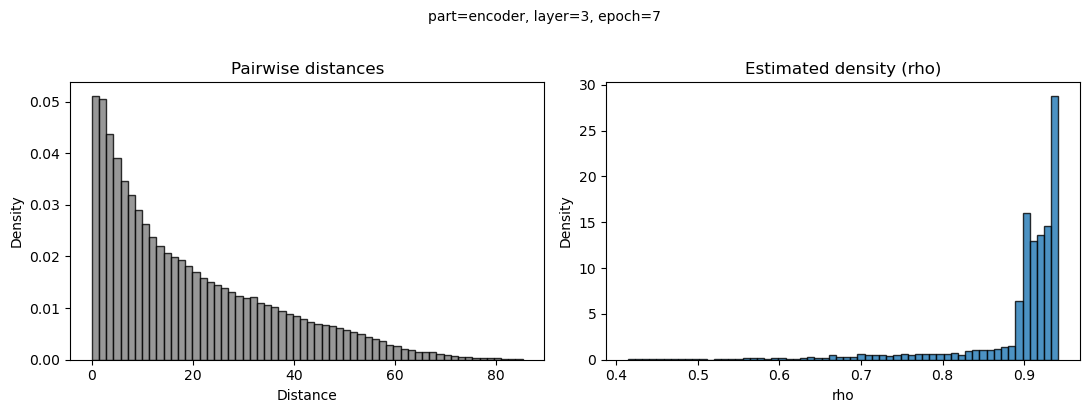

In [41]:
plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="encoder",
    layer=3,
    epoch=7
)

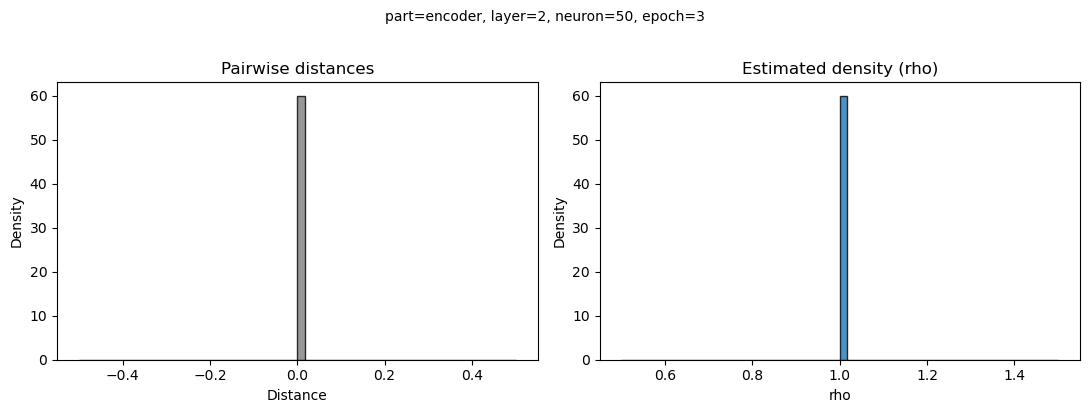

In [46]:
plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="encoder",
    layer=2,
    neuron=50,
    epoch=3
)

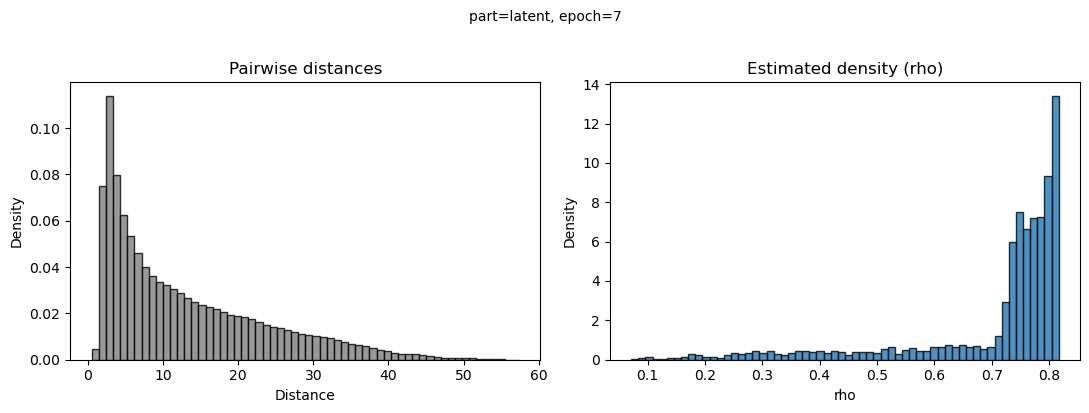

In [43]:
plot_kde_geometry(
    recorder=RecorderActivat,
    kde=kde,
    part="latent",
    epoch=7
)

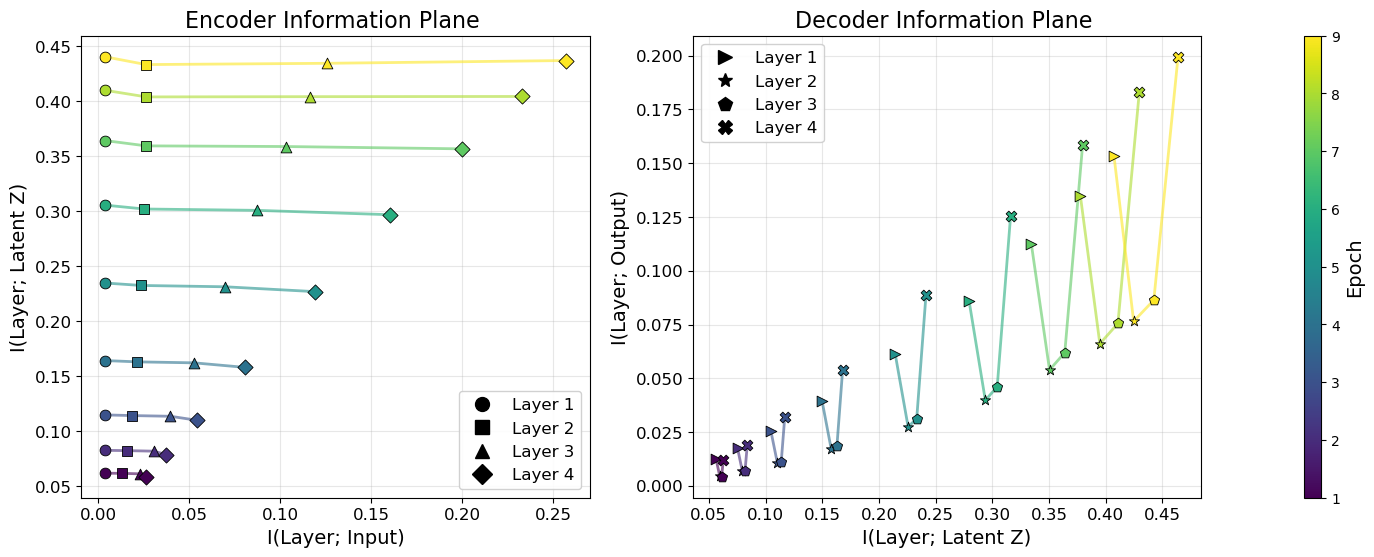

In [36]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=13, Step=1)

In [16]:
epochs = 40
final_loss = Training(model, num_epochs=epochs, showImage=False)

Epoch 1/40: 100%|█████████████████████████████| 120/120 [00:04<00:00, 28.76it/s]


TRAIN — Epoch 1/40 — train loss: 0.1014


Epoch 2/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.89it/s]


TRAIN — Epoch 2/40 — train loss: 0.0637


Epoch 3/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 33.73it/s]


TRAIN — Epoch 3/40 — train loss: 0.0576


Epoch 4/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.62it/s]


TRAIN — Epoch 4/40 — train loss: 0.0512


Epoch 5/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.36it/s]


TRAIN — Epoch 5/40 — train loss: 0.0454


Epoch 6/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.22it/s]


TRAIN — Epoch 6/40 — train loss: 0.0414


Epoch 7/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.07it/s]


TRAIN — Epoch 7/40 — train loss: 0.0386


Epoch 8/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.11it/s]


TRAIN — Epoch 8/40 — train loss: 0.0370


Epoch 9/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.91it/s]


TRAIN — Epoch 9/40 — train loss: 0.0358


Epoch 10/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 35.77it/s]


TRAIN — Epoch 10/40 — train loss: 0.0341


Epoch 11/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.13it/s]


TRAIN — Epoch 11/40 — train loss: 0.0324


Epoch 12/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.13it/s]


TRAIN — Epoch 12/40 — train loss: 0.0309


Epoch 13/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.05it/s]


TRAIN — Epoch 13/40 — train loss: 0.0299


Epoch 14/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.10it/s]


TRAIN — Epoch 14/40 — train loss: 0.0291


Epoch 15/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.30it/s]


TRAIN — Epoch 15/40 — train loss: 0.0284


Epoch 16/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.57it/s]


TRAIN — Epoch 16/40 — train loss: 0.0279


Epoch 17/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.42it/s]


TRAIN — Epoch 17/40 — train loss: 0.0273


Epoch 18/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.83it/s]


TRAIN — Epoch 18/40 — train loss: 0.0268


Epoch 19/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.09it/s]


TRAIN — Epoch 19/40 — train loss: 0.0261


Epoch 20/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.05it/s]


TRAIN — Epoch 20/40 — train loss: 0.0256


Epoch 21/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.88it/s]


TRAIN — Epoch 21/40 — train loss: 0.0252


Epoch 22/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.33it/s]


TRAIN — Epoch 22/40 — train loss: 0.0248


Epoch 23/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.42it/s]


TRAIN — Epoch 23/40 — train loss: 0.0244


Epoch 24/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.37it/s]


TRAIN — Epoch 24/40 — train loss: 0.0241


Epoch 25/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.24it/s]


TRAIN — Epoch 25/40 — train loss: 0.0238


Epoch 26/40: 100%|████████████████████████████| 120/120 [00:02<00:00, 42.68it/s]


TRAIN — Epoch 26/40 — train loss: 0.0234


Epoch 27/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.04it/s]


TRAIN — Epoch 27/40 — train loss: 0.0231


Epoch 28/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.24it/s]


TRAIN — Epoch 28/40 — train loss: 0.0229


Epoch 29/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 35.93it/s]


TRAIN — Epoch 29/40 — train loss: 0.0225


Epoch 30/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.23it/s]


TRAIN — Epoch 30/40 — train loss: 0.0223


Epoch 31/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.02it/s]


TRAIN — Epoch 31/40 — train loss: 0.0221


Epoch 32/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.06it/s]


TRAIN — Epoch 32/40 — train loss: 0.0218


Epoch 33/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.94it/s]


TRAIN — Epoch 33/40 — train loss: 0.0215


Epoch 34/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.81it/s]


TRAIN — Epoch 34/40 — train loss: 0.0213


Epoch 35/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.38it/s]


TRAIN — Epoch 35/40 — train loss: 0.0211


Epoch 36/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.16it/s]


TRAIN — Epoch 36/40 — train loss: 0.0210


Epoch 37/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.11it/s]


TRAIN — Epoch 37/40 — train loss: 0.0208


Epoch 38/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.00it/s]


TRAIN — Epoch 38/40 — train loss: 0.0206


Epoch 39/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.89it/s]


TRAIN — Epoch 39/40 — train loss: 0.0205


Epoch 40/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.15it/s]


TRAIN — Epoch 40/40 — train loss: 0.0203


# 2.bis Debug

In [ ]:
# activations

In [ ]:
# a = activations['decoder_layer_1'].detach().cpu().numpy()[0]
# print(len(a),"\n",a)

In [ ]:
# history_encoder

In [ ]:
# history_decoder

# 3. Results

## VAE outputs

In [17]:
def ShowSomeImages(model, testDataset, device):

    model.eval()
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        img, _ = random.choice(testDataset)

        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            recon, _ = model(x)

        original = img.cpu().squeeze().numpy()
        reconstructed = recon.cpu().squeeze().numpy().reshape(28, 28)

        axs[i, 0].imshow(original, cmap="gist_gray")
        axs[i, 0].set_title("Original")
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])

        axs[i, 1].imshow(reconstructed, cmap="gist_gray")
        axs[i, 1].set_title("Reconstruction")
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

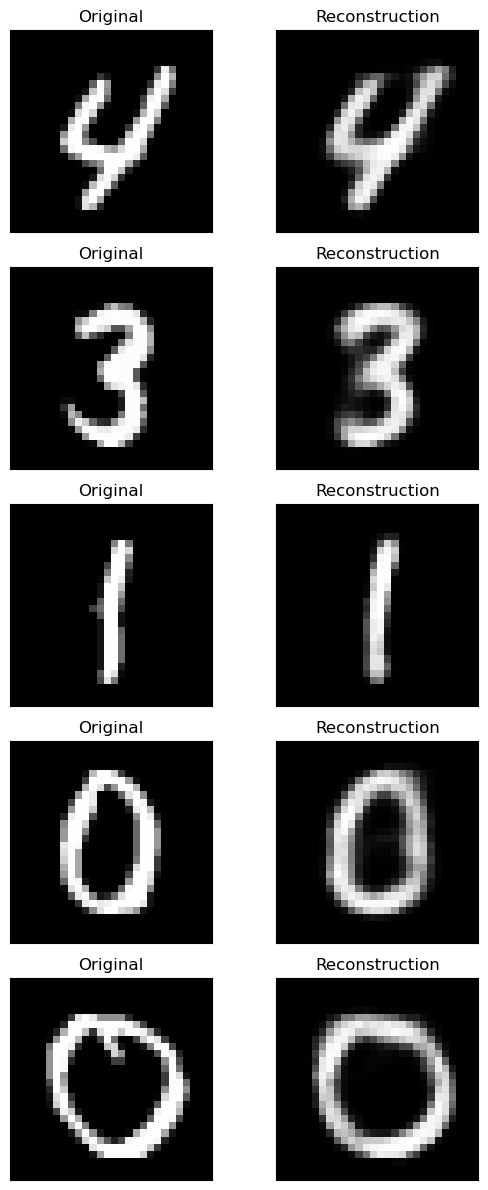

In [18]:
ShowSomeImages(model, testDataset, device)

## VAE loss

In [19]:
def PlotLoss(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_history, color='blue', linewidth=2, label='Training loss')
    plt.plot(epochs, val_loss_history, color='red', linewidth=2, label='Validation loss')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (40,) and (0,)

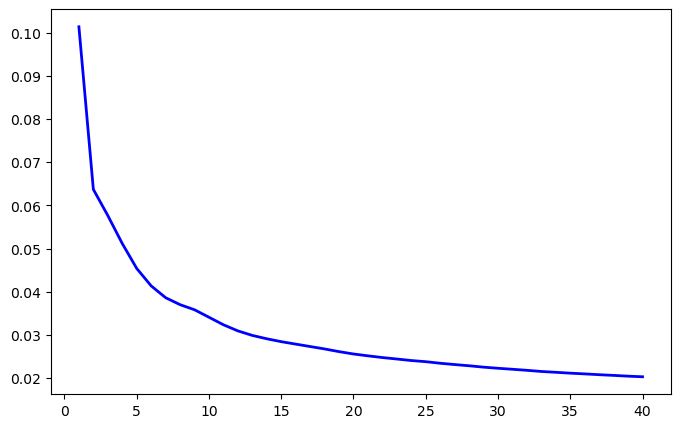

In [20]:
# Variational
PlotLoss(train_loss_history, val_loss_history)

## Mutual Info

In [35]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix="", 
                  start_epoch=1, end_epoch=-1, Step=5):

    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[6, 6, 0.2], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])
    ax_cb  = fig.add_subplot(gs[0, 2])

    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs -1

    # NEW: filter epochs by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if ep % Step == 0]
    epochs = len(epoch_range)

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]

    encoder_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
    decoder_markers = ['>', '*', 'p', 'X', 'H', '>', 'd', 'D', '8', 'o']

    n_layers = len(mi_history_encoder[0])

    # ---------------- ENCODER ----------------
    ax = ax_enc

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_encoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_encoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = encoder_markers[l % len(encoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Input)", fontsize=14)
    ax.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    enc_handles = []
    enc_labels = []
    for l in range(n_layers):
        mk = encoder_markers[l % len(encoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        enc_handles.append(handle)
        enc_labels.append(f'Layer {l+1}')

    ax_enc.legend(enc_handles, enc_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    ax = ax_dec

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_decoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_decoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = decoder_markers[l % len(decoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_ylabel("I(Layer; Output)", fontsize=14)
    ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    dec_handles = []
    dec_labels = []
    for l in range(n_layers):
        mk = decoder_markers[l % len(decoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        dec_handles.append(handle)
        dec_labels.append(f'Layer {l+1}')

    ax_dec.legend(dec_handles, dec_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- COLORBAR ----------------
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=ax_cb, orientation='vertical')
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)
    cbar.set_label("Epoch", fontsize=14)

    plt.show()

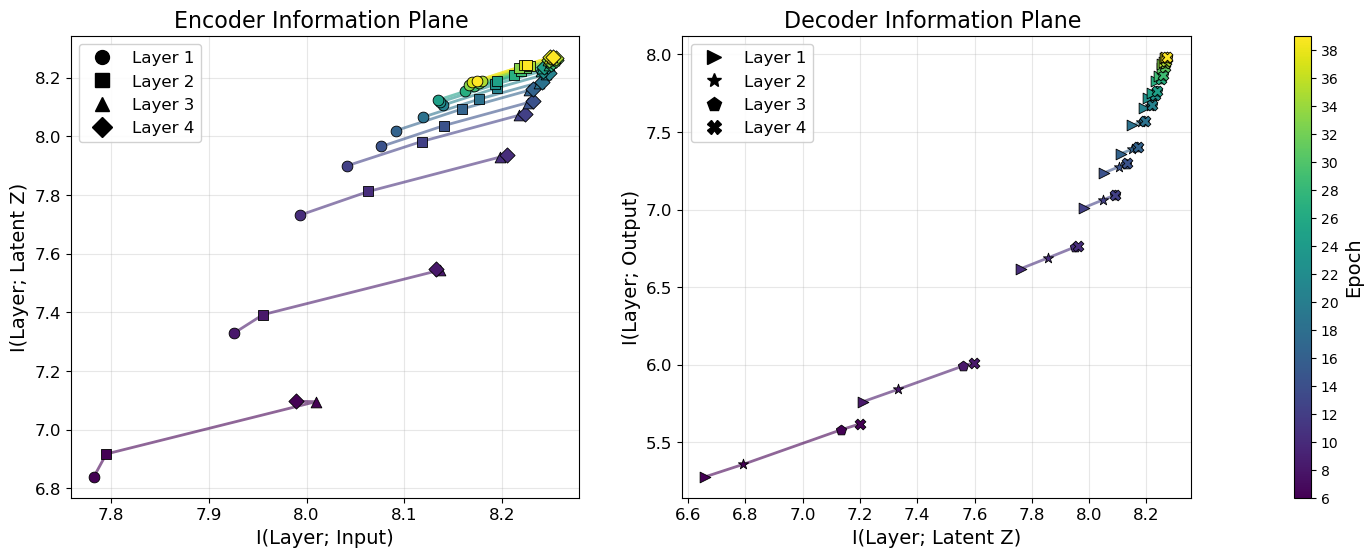

In [23]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

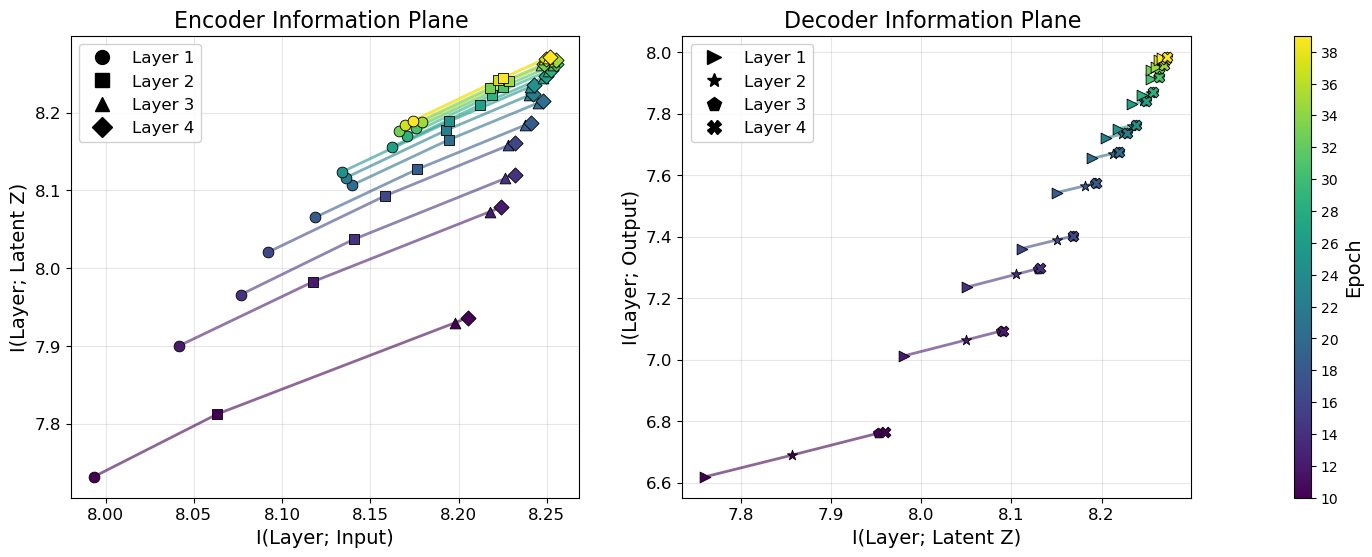

In [30]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=10, end_epoch=40, Step=2)

In [24]:
def PlotInfoPlaneLayers(mi_history_encoder, mi_history_decoder,
                            title_suffix="",
                            start_epoch=1, end_epoch=-1, Step=1):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # --- Select epochs based on user settings ---
    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    # Filter epochs: start → end, stepping by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if (ep - start_epoch) % Step == 0]

    # --- Figure layout ---
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[6, 6], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])

    n_layers = len(mi_history_encoder[0])

    # ----- Color scales -----
    encoder_colors = [plt.cm.Reds((i+1)/n_layers) for i in range(n_layers)]
    decoder_colors = [plt.cm.Blues((i+1)/n_layers) for i in range(n_layers)]

    # marker shapes
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

    # ---------------- ENCODER ----------------
    for l in range(n_layers):
        x = [mi_history_encoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_encoder[ep][l][1] for ep in epoch_range]

        ax_enc.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=encoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_enc.set_xlabel("I(Layer; Input)", fontsize=14)
    ax_enc.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax_enc.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax_enc.grid(True, alpha=0.3)
    ax_enc.tick_params(axis='both', labelsize=12)

    # Encoder legend
    enc_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=encoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_enc.legend(enc_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    for l in range(n_layers):
        x = [mi_history_decoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_decoder[ep][l][1] for ep in epoch_range]

        ax_dec.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=decoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_dec.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax_dec.set_ylabel("I(Layer; Output)", fontsize=14)
    ax_dec.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax_dec.grid(True, alpha=0.3)
    ax_dec.tick_params(axis='both', labelsize=12)

    # Decoder legend
    dec_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=decoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_dec.legend(dec_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    plt.show()

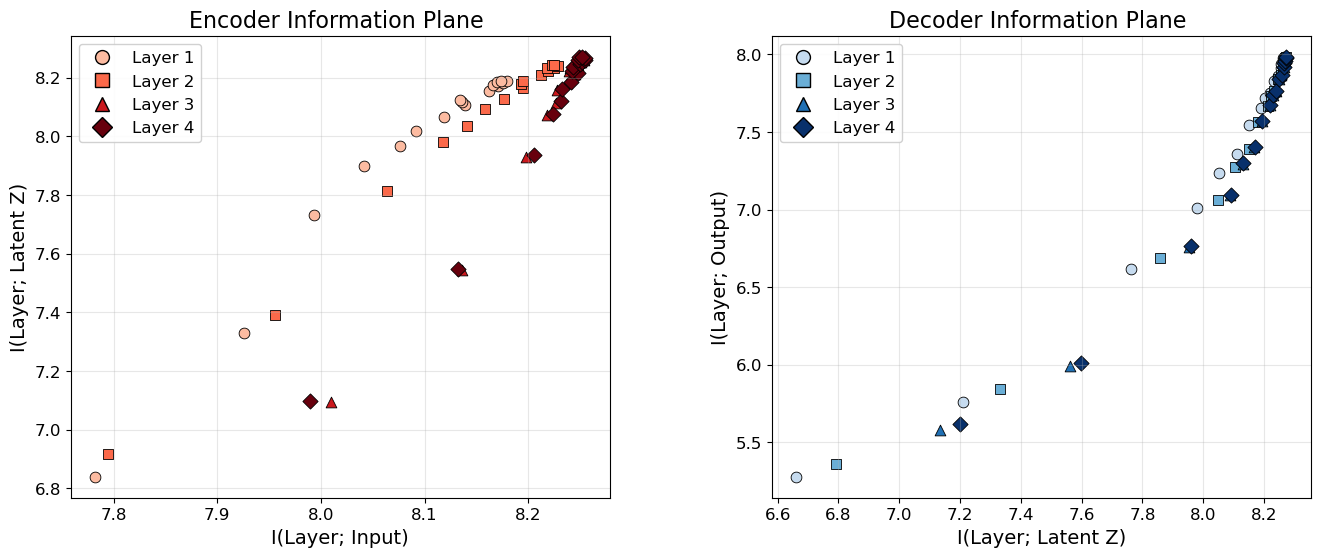

In [25]:
# No variation 80 epoch
PlotInfoPlaneLayers(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

In [28]:
def PlotInputLatentOutput(mi_input_latent, mi_latent_output, title_suffix="", start_epoch=1, end_epoch=-1, Step=5):

    # --- Determine epoch range ---
    total_epochs = len(mi_input_latent)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1)
                   if ep % Step == 0]

    # --- Extract MI values for selected epochs ---
    X_vals = [mi_input_latent[ep] for ep in epoch_range]
    Y_vals = [mi_latent_output[ep] for ep in epoch_range]

    cmap = plt.get_cmap("Greens")
    colors = [cmap(i / max(1, len(epoch_range) - 1)) for i in range(len(epoch_range))]

    fig, ax = plt.subplots(figsize=(7, 6))

    for i, ep in enumerate(epoch_range):
        ax.scatter(
            X_vals[i], Y_vals[i],
            s=80,
            marker='o',
            facecolors=colors[i],
            edgecolors='black',
            linewidths=0.6,
            label=f"Epoch {ep}"
        )

    # Labels and title
    ax.set_xlabel("MI(Input; Latent)", fontsize=14)
    ax.set_ylabel("MI(Latent; Output)", fontsize=14)
    ax.set_title(f"Global Mutual Information {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    # --- Colorbar ---
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Epoch", fontsize=14)
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)

    plt.tight_layout()
    plt.show()

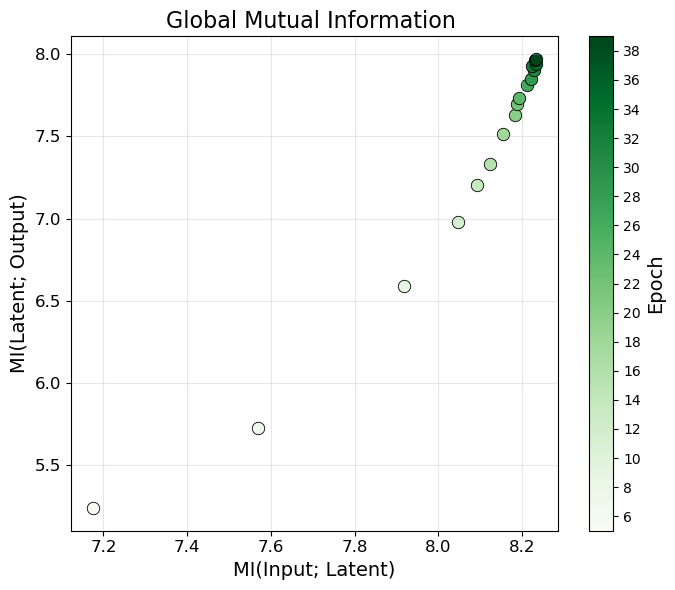

In [29]:
# Variation 40 epoch
PlotInputLatentOutput(history_input_latent, history_latent_output, start_epoch=5, end_epoch=40, Step=2)